In [1]:
import numpy as np
import torch
from torch import nn
%matplotlib notebook

import qucumber
from qucumber.nn_states import PositiveWaveFunction
from qucumber.callbacks import MetricEvaluator, LivePlotting
from qucumber.utils.data import load_data
from qucumber.utils import training_statistics as ts

from masked_rbm import MaskedBinaryRBM

qucumber.set_random_seed(161)

In [2]:
data, psi = load_data("../QuCumber/examples/Tutorial1_TrainPosRealWaveFunction/tfim1d_data.txt", 
                      "../QuCumber/examples/Tutorial1_TrainPosRealWaveFunction/tfim1d_psi.txt")

In [3]:
# Create a mask for the weight matrix by finding the weights
#  with the smallest magnitudes.
def create_mask(matrix, p=0.5):
    vals, _ = matrix.flatten().abs().sort()
    cutoff = vals[int(np.ceil(p * len(vals)))]
    return (matrix.abs() >= cutoff).to(dtype=matrix.dtype)

In [4]:
nn_state = PositiveWaveFunction(10, 10, gpu=False)
space = nn_state.generate_hilbert_space()
weights = nn_state.rbm_am.weights.clone()  # save the initial weights for later

In [5]:
me = MetricEvaluator(50, {"fidelity": ts.fidelity}, 
                     target_psi=psi, verbose=True, space=space)
lp = LivePlotting(50, me, "fidelity")
cbs = [me, lp]

We begin by training the unmasked model for 500 epochs to create a mask.

<IPython.core.display.Javascript object>


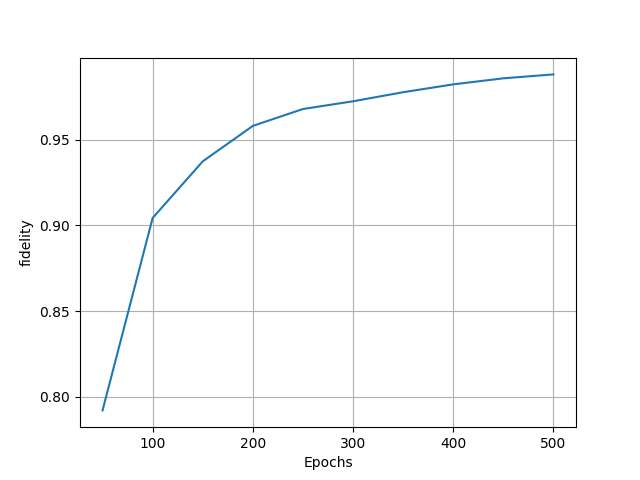

Epoch: 50	fidelity = 0.792118
Epoch: 100	fidelity = 0.904313
Epoch: 150	fidelity = 0.937336
Epoch: 200	fidelity = 0.958010
Epoch: 250	fidelity = 0.967849
Epoch: 300	fidelity = 0.972355
Epoch: 350	fidelity = 0.977644
Epoch: 400	fidelity = 0.982219
Epoch: 450	fidelity = 0.985747
Epoch: 500	fidelity = 0.988031



In [6]:
me.clear_history()  # clear the callback's internal history
nn_state.fit(data, lr=0.01, epochs=500, progbar="notebook", callbacks=cbs)

In [7]:
# mask 50% of the weights which have smallest magnitudes
mask = create_mask(nn_state.rbm_am.weights, p=0.5)
weights2 = (weights * mask)

rbm = MaskedBinaryRBM(10, 10, mask=mask, gpu=False)
rbm.weights = nn.Parameter(weights2)

In [8]:
nn_state2 = PositiveWaveFunction(10, 10, gpu=False)
nn_state2.rbm_am = rbm  # replace the internal RBM of this wavefunction object

<IPython.core.display.Javascript object>


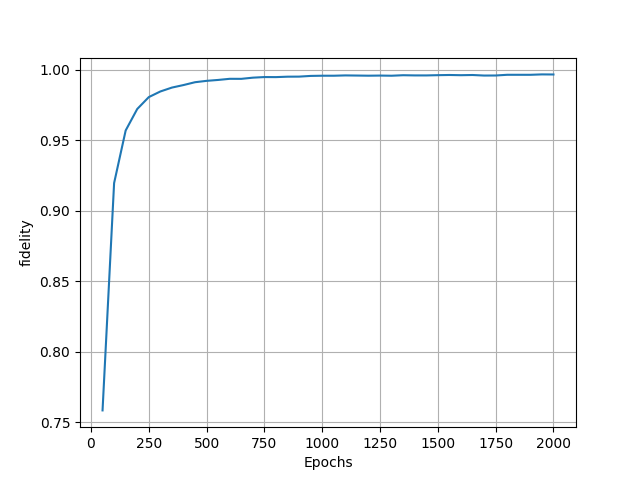

Epoch: 50	fidelity = 0.758263
Epoch: 100	fidelity = 0.919552
Epoch: 150	fidelity = 0.956874
Epoch: 200	fidelity = 0.972114
Epoch: 250	fidelity = 0.980552
Epoch: 300	fidelity = 0.984544
Epoch: 350	fidelity = 0.987308
Epoch: 400	fidelity = 0.989101
Epoch: 450	fidelity = 0.991115
Epoch: 500	fidelity = 0.992084
Epoch: 550	fidelity = 0.992730
Epoch: 600	fidelity = 0.993530
Epoch: 650	fidelity = 0.993506
Epoch: 700	fidelity = 0.994342
Epoch: 750	fidelity = 0.994777
Epoch: 800	fidelity = 0.994735
Epoch: 850	fidelity = 0.995039
Epoch: 900	fidelity = 0.995086
Epoch: 950	fidelity = 0.995586
Epoch: 1000	fidelity = 0.995722
Epoch: 1050	fidelity = 0.995717
Epoch: 1100	fidelity = 0.995941
Epoch: 1150	fidelity = 0.995845
Epoch: 1200	fidelity = 0.995738
Epoch: 1250	fidelity = 0.995831
Epoch: 1300	fidelity = 0.995717
Epoch: 1350	fidelity = 0.996073
Epoch: 1400	fidelity = 0.995939
Epoch: 1450	fidelity = 0.995930
Epoch: 1500	fidelity = 0.996110
Epoch: 1550	fidelity = 0.996243
Epoch: 1600	fidelity = 0.996

In [9]:
me.clear_history()
nn_state2.fit(data, lr=0.01, epochs=2000, progbar="notebook", callbacks=cbs)

Note that at the 500th epoch, the fidelity is already higher than that of the original (unmasked) model at the same epoch. We let the model train further just to make sure the fidelity doesn't plateau, and to see how well the training converges. I found that fidelity does start plateau-ing earlier than 99% fidelity when more than 70% of the weights are being pruned. 65% pruning gave a plateau around 99.2% fidelity, 70% pruning gave a plateau around 97.5% fidelity, 80% pruning plateau'd around 86% fidelity, 90% pruning plateau'd around 57% fidelity.

Next, we check the fidelity of the masked model when its weights are set to their initial values. We don't worry about the biases as they are, by default, set to 0 upon initialization of the model.

In [10]:
nn_s = PositiveWaveFunction(10,10,gpu=False)
nn_s.rbm_am.weights = nn.Parameter(weights.clone() * mask)

In [11]:
ts.fidelity(nn_s, psi, space)

0.4498844459933284

Compare to the fidelity of a model with identical initial parameters, but with no masking applied:

In [12]:
nn_s_unmasked = PositiveWaveFunction(10,10,gpu=False)
nn_s_unmasked.rbm_am.weights = nn.Parameter(weights.clone())
ts.fidelity(nn_s_unmasked, psi, space)

0.4262501000717602

We see that masking improves the initial model. Lastly, we will train this model for 2000 epochs to compare the performance of the masked model.

<IPython.core.display.Javascript object>


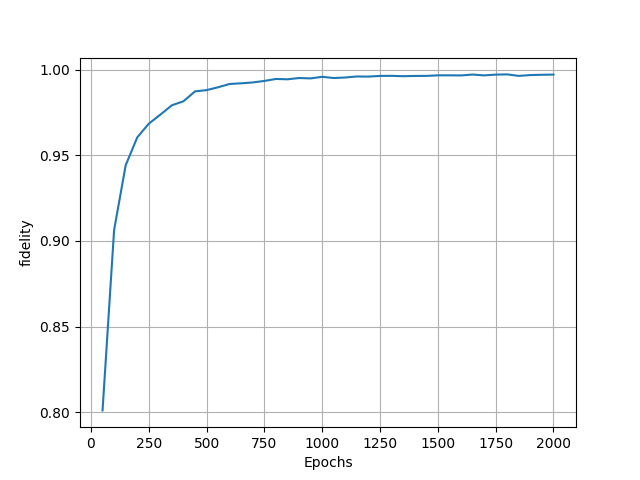

Epoch: 50	fidelity = 0.801124
Epoch: 100	fidelity = 0.906410
Epoch: 150	fidelity = 0.944158
Epoch: 200	fidelity = 0.960461
Epoch: 250	fidelity = 0.968468
Epoch: 300	fidelity = 0.973751
Epoch: 350	fidelity = 0.979213
Epoch: 400	fidelity = 0.981559
Epoch: 450	fidelity = 0.987330
Epoch: 500	fidelity = 0.988058
Epoch: 550	fidelity = 0.989736
Epoch: 600	fidelity = 0.991653
Epoch: 650	fidelity = 0.992030
Epoch: 700	fidelity = 0.992547
Epoch: 750	fidelity = 0.993428
Epoch: 800	fidelity = 0.994569
Epoch: 850	fidelity = 0.994378
Epoch: 900	fidelity = 0.995121
Epoch: 950	fidelity = 0.994897
Epoch: 1000	fidelity = 0.995828
Epoch: 1050	fidelity = 0.995118
Epoch: 1100	fidelity = 0.995427
Epoch: 1150	fidelity = 0.996025
Epoch: 1200	fidelity = 0.995952
Epoch: 1250	fidelity = 0.996344
Epoch: 1300	fidelity = 0.996395
Epoch: 1350	fidelity = 0.996180
Epoch: 1400	fidelity = 0.996331
Epoch: 1450	fidelity = 0.996367
Epoch: 1500	fidelity = 0.996679
Epoch: 1550	fidelity = 0.996699
Epoch: 1600	fidelity = 0.996

In [13]:
me.clear_history()
nn_s.fit(data, lr=0.01, epochs=2000, progbar="notebook", callbacks=cbs)

At epoch 2000, the unmasked model seems to have won out slightly, but the fidelities are too close together to make any solid conclusion. If we consider that the mask required 500 training epochs to produce, it makes more sense to compare the 1500th epoch of the masked model to the 2000th epoch of the unmasked. These two values are still relatively close together. Due to the closeness of the fidelities, it doesn't really make much sense to draw conclusions on each model's relative performance from these figures. Indeed, with the right random seed, the masked model sometimes wins out. 

We *can*, however, conclude that even with only half the number of weights, the RBM is still able to reconstruct the desired wavefunction with about the same accuracy.